## Word Embeddings

Word Embeddings are dense vectors representations of words.

Word embeddings compress information so you have a more dense representation. Compare this to sparse vectors like One-Hot Encoding.


In [1]:
sentence = "the quick brown fox jumped over the lazy dog"

words = sentence.split()
print(words)

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']


Let's look at the individual words in our vocabulary:


In [2]:
vocab1 = list(set(words))
print(vocab1)

['quick', 'fox', 'the', 'lazy', 'brown', 'dog', 'over', 'jumped']


In [3]:
len(vocab1)

8

## One Hot Encoding
The vocabulary size is seen above. Now we can one-hot encode the vocabulary words. The good news is that PyTorch (As of December 2018) now has a built-in one-hot encoding module

In [4]:
# convert words to indexes
word_to_ix1 = {word: i for i, word in enumerate(vocab1)}
word_to_ix1

{'quick': 0,
 'fox': 1,
 'the': 2,
 'lazy': 3,
 'brown': 4,
 'dog': 5,
 'over': 6,
 'jumped': 7}

In [5]:
import torch
from torch.nn.functional import one_hot

words = torch.tensor([word_to_ix1[w] for w in vocab1], dtype=torch.long)

one_hot_encodding = one_hot(words)
print(vocab1)
print(words)
print(one_hot_encodding)

['quick', 'fox', 'the', 'lazy', 'brown', 'dog', 'over', 'jumped']
tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]])


The issue with sparse one-hot encoding is that the vectors are very large and we have a very sparse representation of the vectors. As you can see there are a lot of zeros. For example, the popular data set WikiText-103 has 267,000 words in the vocabulary. This means around 267,000 zeros in each vector with one-hot encoding.

We should try to find a smaller encoding for our dataset. Let's try a denser vector using a Word Embedding.

## Word Embedding Example


In [6]:
# Context is the number of words we are using as a context for the next word we want to predict
CONTEXT_SIZE = 2

# Embedding dimension is the size of the embedding vector
EMBEDDING_DIM = 10

# Size of the hidden layer
HIDDEN_DIM = 256

In [7]:
# We will use Shakespeare Sonnet 2
test_sentence = """Tomorrow, and tomorrow, and tomorrow,
Creeps in this petty pace from day to day,
To the last syllable of recorded time;
And all our yesterdays have lighted fools
The way to dusty death. Out, out, brief candle!
Life's but a walking shadow, a poor player,
That struts and frets his hour upon the stage,
And then is heard no more. It is a tale
Told by an idiot, full of sound and fury,
Signifying nothing.
""".lower().split()

len(test_sentence)

75

In [14]:
test_sentence[:5]

['tomorrow,', 'and', 'tomorrow,', 'and', 'tomorrow,']

In [17]:
# Build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)

trigrams = [([test_sentence[i], test_sentence[i+1]], test_sentence[i+2])
    for i in range(len(test_sentence)-2)
]

print(trigrams[:3])

[(['tomorrow,', 'and'], 'tomorrow,'), (['and', 'tomorrow,'], 'and'), (['tomorrow,', 'and'], 'tomorrow,')]


In [18]:
vocab2 = list(set(test_sentence))

word_to_ix2 = {word:i for i, word in enumerate(vocab2)}
word_to_ix2

{'fools': 0,
 'walking': 1,
 'but': 2,
 'an': 3,
 'signifying': 4,
 'dusty': 5,
 'that': 6,
 'idiot,': 7,
 'yesterdays': 8,
 'time;': 9,
 'our': 10,
 'by': 11,
 'his': 12,
 'tomorrow,': 13,
 'nothing.': 14,
 'no': 15,
 'frets': 16,
 'heard': 17,
 'from': 18,
 'in': 19,
 'a': 20,
 'poor': 21,
 'then': 22,
 'petty': 23,
 'all': 24,
 'to': 25,
 'the': 26,
 'way': 27,
 'lighted': 28,
 'is': 29,
 'day': 30,
 'fury,': 31,
 'this': 32,
 'and': 33,
 'tale': 34,
 "life's": 35,
 'hour': 36,
 'full': 37,
 'recorded': 38,
 'stage,': 39,
 'told': 40,
 'have': 41,
 'day,': 42,
 'sound': 43,
 'candle!': 44,
 'player,': 45,
 'upon': 46,
 'last': 47,
 'out,': 48,
 'more.': 49,
 'shadow,': 50,
 'it': 51,
 'pace': 52,
 'syllable': 53,
 'creeps': 54,
 'of': 55,
 'death.': 56,
 'brief': 57,
 'struts': 58}

## N-Gram Language Model
An N-Gram is a sequence of words as in a sentence. This is useful because it gives us some context to train a deep learning classifier.

Here's what a diagram of our n-gram deep learning model would look like:

![n-gram deep learning model](data/network_next_word.png)



## Training is based on preceding words
Predict the probability of a word based on the words around it

In [19]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, HIDDEN_DIM)
        self.linear2 = nn.Linear(HIDDEN_DIM, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [22]:
learning_rate = 1e-3
epochs = 25
losses = []
loss_function = nn.NLLLoss() # negative log likelihood + log_softmaxt = Cross Entropy

model= NGramLanguageModeler(len(vocab2), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
from tqdm import tqdm

for epoch in range(epochs):
    total_loss = 0
    iterator = tqdm(trigrams)
    for context, target in iterator:
        # (['When', 'forty'], 'winters')
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix2[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old instance
        optimizer.zero_grad()

        # Step 3. forward pass, getting log probabilities over next words
        log_probs = model(context_idxs)

        # Step 4. loss
        loss = loss_function(log_probs, torch.tensor([word_to_ix2[target]], dtype=torch.long))

        # Step 5. backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        iterator.set_postfix(loss=float(loss))

    losses.append(total_loss)

100%|██████████| 73/73 [00:00<00:00, 140.93it/s, loss=3.31]


In [24]:
# Check the structure of our model here
model.eval()

NGramLanguageModeler(
  (embeddings): Embedding(59, 10)
  (linear1): Linear(in_features=20, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=59, bias=True)
)

In [25]:
len(vocab2)

59

Let's try this out!

In [34]:
import numpy as np

with torch.no_grad():
    context = ['tomorrow,', 'and']
    context_idxs = torch.tensor([word_to_ix2[w] for w in context], dtype=torch.long)
    pred = model(context_idxs)
    print(pred)

    ix_of_pred = np.argmax(pred)
    print(ix_of_pred)
    print(vocab2[ix_of_pred])

tensor([[-4.5194, -4.4980, -4.6106, -4.0331, -4.2452, -4.5243, -4.1632, -4.4549,
         -4.5684, -4.0000, -4.5083, -4.3641, -3.9523, -2.6807, -4.8401, -4.6424,
         -4.6577, -3.8184, -4.3784, -4.0063, -3.4362, -4.1825, -3.9764, -4.4263,
         -3.8398, -3.5312, -4.0631, -4.1231, -4.1584, -3.9082, -4.7878, -4.0765,
         -4.5929, -2.7689, -4.5393, -4.1650, -4.2256, -4.2120, -4.4710, -4.0513,
         -4.0130, -4.2901, -3.8652, -4.6372, -4.5354, -4.4602, -4.5569, -4.0463,
         -4.0396, -4.0004, -4.3012, -4.0981, -4.2954, -3.9654, -4.3180, -3.5095,
         -4.0772, -4.4340, -4.2695]])
tensor(13)
tomorrow,


## Exercise: Continuous Bag of Words
Continuous Bag of Words is a model that tries to predict a word based on a few word before and after the word.

In [35]:

CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

In [36]:
vocab3 = list(set(raw_text))
vocab3_size = len(vocab3)

word_to_ix3 = {word:i for i, word in enumerate(vocab3)}

In [37]:
data = [] # for training

for i in range(2, len(raw_text) - 2):
    context = [raw_text[i-2], raw_text[i-1], raw_text[i+1], raw_text[i+2]]
    target = raw_text[i]
    data.append((context, target))

print(data[:2])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to')]


In [39]:
# create your model and train.  here are some functions to help you make
# the data ready for use by your module
def make_context_vector(context, word_to_ix3):
    idxs = [word_to_ix3[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

# test
make_context_vector(data[0][0], word_to_ix3)

tensor([28, 34, 19, 29])

In [40]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.l1 = nn.Linear(context_size*2*embedding_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.l1(embeds))
        out = self.l2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [41]:
learning_rate = 0.001
epochs = 25
losses = []
loss_function = nn.NLLLoss()
model = CBOW(vocab3_size, 10, 256, 2)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
for epoch in range(epochs):
    total_loss = 0

    iterator = tqdm(data)
    for context, target in iterator:
        context_idxs = make_context_vector(context, word_to_ix3)
        target_vect = torch.tensor([word_to_ix3[target]],dtype=torch.long)

        # zero grad
        optimizer.zero_grad()

        # forward pass, calculate loss
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, target_vect)

        # backward pass, update parameters
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        iterator.set_postfix(loss=loss.item())
    
    losses.append(total_loss)

100%|██████████| 58/58 [00:00<00:00, 129.13it/s, loss=2.77]


In [43]:
import matplotlib.pyplot as plt 
%matplotlib inline

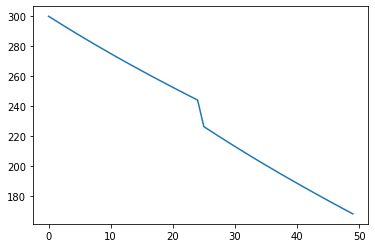

In [44]:
plt.plot(losses)
plt.show()

In [45]:
model.eval()

CBOW(
  (embeddings): Embedding(49, 10)
  (l1): Linear(in_features=40, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=49, bias=True)
)

In [46]:

import numpy

with torch.no_grad():
    context = ['Computational', 'processes', 'abstract', 'beings']
    context_idxs = torch.tensor([word_to_ix3[w] for w in context], dtype=torch.long)
    pred = model(context_idxs)
    print(pred)
    index_of_prediction = numpy.argmax(pred)
    print(vocab3[index_of_prediction])

tensor([[-3.8374, -4.1494, -3.9322, -4.1474, -4.2296, -3.2942, -3.9723, -4.7009,
         -4.1333, -4.6231, -4.2210, -4.3470, -4.0877, -4.1785, -3.0125, -4.0918,
         -4.0958, -4.8311, -3.9875, -4.2706, -3.0406, -4.0187, -4.3088, -4.3530,
         -4.1002, -3.9901, -3.9967, -3.4077, -4.8669, -4.4567, -4.0563, -3.6777,
         -4.0914, -4.7685, -2.5994, -3.7635, -3.6721, -4.0759, -3.3512, -3.6868,
         -3.8181, -3.4975, -4.2904, -4.2967, -4.2187, -4.8899, -4.1274, -3.2103,
         -4.1965]])
are
